# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Setup](#Setup)
* [C](#C)
* [Discussion](#Discussion)

# Introduction

tune a logreg

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2022)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd
from scipy.stats import loguniform

# utility
from copy import deepcopy
from gc import collect as gc_collect

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

import swifter

# typing
from typing import Dict, List, Sequence

# other sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, StratifiedGroupKFold

# params
from scipy.stats import loguniform, uniform

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib widget

sns.set_context("notebook")

# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 3.06 s


In [4]:
# Location of pre-final labels and features
FEATURES_FOLDER = "."

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 113 ms


# Setup

In [5]:
def load_labels() -> pd.DataFrame:
    """Load just the labels"""
    return pd.read_feather(f"{FEATURES_FOLDER}/simplified_labels.feather").set_index(
        "id"
    )


def load_data() -> pd.DataFrame:
    """Loads the FRILL-based features"""
    df = pd.read_feather(
        f"{FEATURES_FOLDER}/scaled_features_ready_for_selection.feather"
    ).set_index("id")
    df.columns = df.columns.astype(str)
    return df


data = load_data()
labels = load_labels()
GNB_FEATURES = ["spherical-LDA1", "spherical-LDA2"]
data = data.loc[:, GNB_FEATURES]
assert all(data.index == labels.index)
assert len(data) < 86000
y_true = labels.valence
_ = gc_collect()

time: 232 ms


In [6]:
data.info()
labels.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 85740 entries, 0 to 87363
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   spherical-LDA1  85740 non-null  float64
 1   spherical-LDA2  85740 non-null  float64
dtypes: float64(2)
memory usage: 2.0 MB
<class 'pandas.core.frame.DataFrame'>
UInt64Index: 85740 entries, 0 to 87363
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   file            85740 non-null  object  
 1   source          85740 non-null  category
 2   speaker_id      85740 non-null  category
 3   speaker_gender  85740 non-null  category
 4   emo             85740 non-null  category
 5   valence         85740 non-null  int8    
 6   neg             85740 non-null  bool    
 7   neu             85740 non-null  bool    
 8   pos             85740 non-null  bool    
 9   lang1           85740 non-null  category
 10  leng

# Strata

In [7]:
N_SPLITS = 8

# fields are concatentated for quick permutation omitting non-existent combos
strata = labels.loc[
    :, ["source", "speaker_gender", "emo", "valence", "lang1", "length"]
]
strata.valence = strata.valence.astype(str)
strata = strata.swifter.apply("".join, axis=1)

Dask Apply: 100%|██████████| 16/16 [00:02<00:00,  6.33it/s]


time: 5.39 s


In [8]:
# utility function for identifying strata with only i occurences
def get_solo(i: int, strata_: pd.Series) -> np.ndarray:
    """Given a series of stratum memberships, return a shuffled array of strata with only i members."""
    return np.unique(
        strata_.loc[
            strata_.isin(
                (strata_counts := strata_.value_counts())
                .where(strata_counts == i)
                .dropna()
                .index
            )
        ]
        .sample(frac=1, random_state=SEED)
        .values
    )


# get solos, print stuff
def get_onlys(
    strata_: pd.Series, print_me: str = "", n_splits: int = N_SPLITS
) -> List[Dict[int, np.ndarray]]:
    """Optinally prints something and returns calls of get_solo on strata_ in a list"""
    print(print_me)
    solos = []
    for i in range(1, n_splits):
        solo: np.ndarray = get_solo(i, strata_)
        print(f"only {i}:", (_ := solo.size))
        if _:  # >= 1 strata with only i samples
            solos.append({i: solo})
    return solos


def process_strata(strata: pd.Series, n_splits: int = N_SPLITS) -> pd.Series:
    """Corrects strata membership column according to n_splits"""

    count = get_onlys_calls = 0

    while onlys := get_onlys(
        strata,
        print_me=f"merge passes performed: {get_onlys_calls}",
        n_splits=n_splits,
    ):
        get_onlys_calls += 1
        if len(onlys) == 1:
            last = onlys[0]
            strata_to_merge: np.ndarray = list(last.values())[0]
            only_key = list(last.keys())[0]
            tuplet_size = n_splits // only_key + (1 if n_splits % only_key else 0)
            # perform tuplet merge
            interval = len(strata_to_merge) // n_splits
            for strata_tuplet in zip(
                *[
                    strata_to_merge[interval * i : interval * (i + 1)]
                    for i in range(tuplet_size)
                ]
            ):
                strata = strata.replace(strata_tuplet, f"stratum_group_{count}")
                count += 1
            remainder = strata_to_merge[tuplet_size * interval :]
            if len(remainder) == 1:
                # process remainder unmatched
                n = n_splits
                strata_counts = strata.value_counts()
                while not (candidates := strata_counts.loc[strata_counts == n]).size:
                    n += 1
                strata = strata.replace(
                    [remainder[0], candidates.sample(n=1, random_state=SEED).index[0]],
                    f"stratum_group_{count}",
                )
                count += 1
            else:
                # self-pair last
                remainder = remainder.tolist()
                while len(remainder) >= 2:
                    strata = strata.replace(
                        (remainder.pop(), remainder.pop()), f"stratum_group_{count}"
                    )
                    count += 1
        else:
            pop_onlys = lambda _: list(onlys.pop(_).values())[0].tolist()
            while len(onlys) >= 2:
                # pop the ends
                shortside = pop_onlys(0)
                longside = pop_onlys(-1)
                # merge until one end empty
                while shortside and longside:
                    strata = strata.replace(
                        (shortside.pop(), longside.pop()), f"stratum_group_{count}"
                    )
                    count += 1
            if onlys:
                # self-pair middle
                remainder = pop_onlys(0)
                while len(remainder) >= 2:
                    strata = strata.replace(
                        (remainder.pop(), remainder.pop()), f"stratum_group_{count}"
                    )
                    count += 1
    return strata


_ = gc_collect()

time: 116 ms


In [9]:
STRATA = process_strata(strata, n_splits=N_SPLITS)
STRATA.value_counts()
cross_validator = lambda: StratifiedGroupKFold(
    n_splits=N_SPLITS, shuffle=True, random_state=SEED
).split(X=data, y=STRATA, groups=labels.speaker_id)

merge passes performed: 0
only 1: 52
only 2: 37
only 3: 31
only 4: 17
only 5: 27
only 6: 13
only 7: 9
merge passes performed: 1
only 1: 43
only 2: 24
only 3: 4
only 4: 1
only 5: 0
only 6: 0
only 7: 0
merge passes performed: 2
only 1: 42
only 2: 20
only 3: 0
only 4: 0
only 5: 5
only 6: 0
only 7: 0
merge passes performed: 3
only 1: 37
only 2: 0
only 3: 0
only 4: 10
only 5: 0
only 6: 5
only 7: 0
merge passes performed: 4
only 1: 32
only 2: 0
only 3: 0
only 4: 0
only 5: 0
only 6: 0
only 7: 5
merge passes performed: 5
only 1: 27
only 2: 0
only 3: 0
only 4: 0
only 5: 0
only 6: 0
only 7: 0
merge passes performed: 6
only 1: 1
only 2: 1
only 3: 0
only 4: 0
only 5: 0
only 6: 0
only 7: 0
merge passes performed: 7
only 1: 0
only 2: 0
only 3: 1
only 4: 0
only 5: 0
only 6: 0
only 7: 0
merge passes performed: 8
only 1: 0
only 2: 0
only 3: 0
only 4: 0
only 5: 0
only 6: 0
only 7: 0


MELDmneu1engmedium               2905
MELDfneu1engmedium               2452
esdmang0cmnmedium                1750
esdmneu1cmnmedium                1750
esdmhap2cmnmedium                1750
esdfneu1engmedium                1750
esdfhap2engmedium                1750
esdfsur0engmedium                1750
esdmsur0engmedium                1749
esdfneu1cmnmedium                1749
esdfhap2cmnmedium                1749
esdmsur0cmnmedium                1749
esdfang0engmedium                1748
esdmneu1engmedium                1747
esdfang0cmnmedium                1747
esdmang0engmedium                1746
esdmhap2engmedium                1744
esdfsad0engmedium                1744
esdfsur0cmnmedium                1737
esdmsad0engmedium                1735
esdmsad0cmnmedium                1713
LEGOv2fneu1engmedium             1673
esdfsad0cmnmedium                1474
LEGOv2mneu1engmedium             1309
MELDfhap2engmedium                931
MELDmhap2engmedium                908
EmoV-DB_sort

time: 1.87 s


# Hyperparameters

In [10]:
model = RandomizedSearchCV(
    estimator=LogisticRegression(
        # tol=1e-5,
        class_weight="balanced",
        random_state=SEED,
        solver="lbfgs",
        max_iter=1000,
        verbose=1,
        n_jobs=-1,
    ),
    param_distributions={
        "C": loguniform(1e-5, 1e5),
    },
    n_iter=10,
    scoring="neg_log_loss",
    n_jobs=-1,
    cv=list(cross_validator()),
    verbose=1,
    random_state=SEED + 1,
    error_score="raise",
).fit(data, labels.valence)

Fitting 8 folds for each of 10 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


time: 11.7 s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


-0.7990104412945365
{'C': 0.016591400233736085}


<AxesSubplot:xlabel='param_C'>

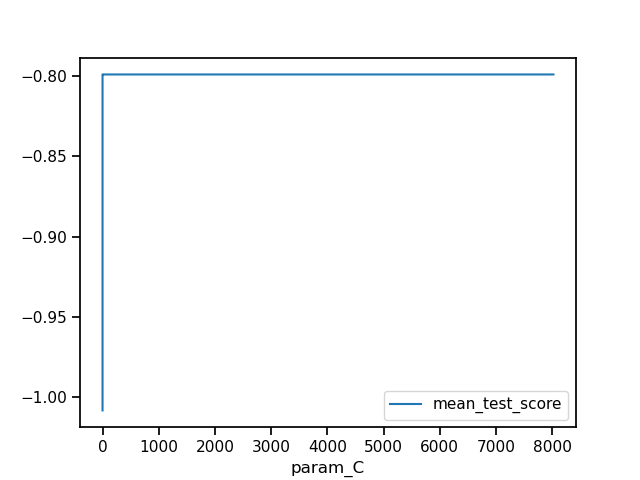

time: 213 ms


In [11]:
print(model.best_score_)
print(model.best_params_)
results_df = (
    pd.DataFrame(model.cv_results_)
    .sort_values(by="param_C", ascending=True)
    .loc[:, ["param_C", "mean_test_score"]]
)
results_df.plot(x="param_C", y="mean_test_score")
plt.show()

In [12]:
df = pd.DataFrame(model.cv_results_)
df.sort_values(by="mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
0,0.560752,0.026484,0.011375,0.002342,0.016591,{'C': 0.016591400233736085},-0.972385,-0.720558,-0.700699,-0.866742,-0.777464,-0.766565,-0.819143,-0.768528,-0.799010,0.081638,1
5,0.584625,0.024062,0.015626,0.007414,0.477481,{'C': 0.47748081089653666},-0.974327,-0.720009,-0.699988,-0.867315,-0.777188,-0.766126,-0.819112,-0.768353,-0.799052,0.082424,2
8,0.592351,0.033514,0.015554,0.010527,1.753369,{'C': 1.7533693991680015},-0.974380,-0.719995,-0.699970,-0.867331,-0.777182,-0.766115,-0.819111,-0.768350,-0.799054,0.082445,3
9,0.534468,0.056820,0.009754,0.003454,2.814183,{'C': 2.814183342742093},-0.974388,-0.719993,-0.699967,-0.867333,-0.777181,-0.766113,-0.819111,-0.768349,-0.799054,0.082448,4
2,0.574253,0.028649,0.011496,0.002448,7.594909,{'C': 7.594908647888714},-0.974396,-0.719991,-0.699964,-0.867336,-0.777180,-0.766112,-0.819111,-0.768349,-0.799055,0.082451,5
7,0.586125,0.044232,0.013876,0.005060,187.390309,{'C': 187.39030866445944},-0.974400,-0.719990,-0.699963,-0.867337,-0.777179,-0.766111,-0.819111,-0.768348,-0.799055,0.082453,6
1,0.573499,0.030317,0.011873,0.002849,8020.926153,{'C': 8020.926152914172},-0.974400,-0.719990,-0.699963,-0.867337,-0.777179,-0.766111,-0.819111,-0.768348,-0.799055,0.082453,7
4,0.477913,0.020130,0.012126,0.004013,0.000259,{'C': 0.00025906707739723275},-0.948195,-0.765480,-0.754070,-0.880257,-0.813060,-0.809714,-0.843640,-0.805337,-0.827469,0.059019,8
3,0.448332,0.029832,0.010860,0.005048,0.000184,{'C': 0.00018448494667907853},-0.950791,-0.781990,-0.772957,-0.890017,-0.827313,-0.825780,-0.854940,-0.820521,-0.840539,0.054314,9
6,0.466874,0.059115,0.014253,0.008828,0.000017,{'C': 1.663016722050822e-05},-1.039044,-0.985439,-0.988680,-1.025222,-1.003991,-1.008787,-1.009471,-1.003720,-1.008044,0.016507,10


time: 31 ms


In [13]:
def tune(C: Sequence, results_df: pd.DataFrame, n_iter: int = 10) -> pd.DataFrame:
    """Run tuning procedure"""
    model = RandomizedSearchCV(
        estimator=LogisticRegression(
            class_weight="balanced",
            random_state=SEED,
            max_iter=1000,
            verbose=1,
            n_jobs=-1,
        ),
        param_distributions={"C": C},
        n_iter=n_iter,
        scoring="neg_log_loss",
        n_jobs=-1,
        cv=list(cross_validator()),
        verbose=1,
        random_state=SEED + 2,
        error_score="raise",
    ).fit(data, labels.valence)

    print("best score:", model.best_score_)
    print("best params:", model.best_params_)
    df = (
        pd.DataFrame(model.cv_results_)
        .sort_values(by="param_C", ascending=True)
        .loc[:, ["param_C", "mean_test_score"]]
    )
    df.plot(x="param_C", y="mean_test_score")
    plt.show()
    return pd.concat(
        [results_df.loc[:, ["param_C", "mean_test_score"]], df],
        axis="rows",
    )


_ = gc_collect()

time: 119 ms


Fitting 8 folds for each of 11 candidates, totalling 88 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best score: -0.7990495099610337
best params: {'C': 0.2396348037505133}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


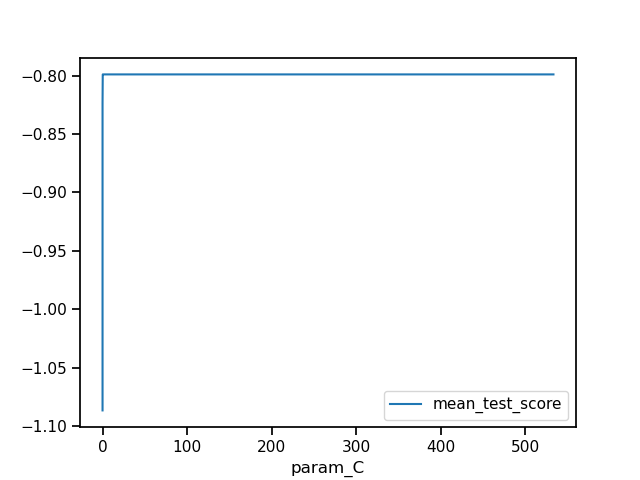

time: 8.82 s


In [14]:
df = tune(C=loguniform(1e-6, 1e6), results_df=df, n_iter=11)

Fitting 8 folds for each of 11 candidates, totalling 88 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best score: -0.7990515080406486
best params: {'C': 0.385803884305235}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


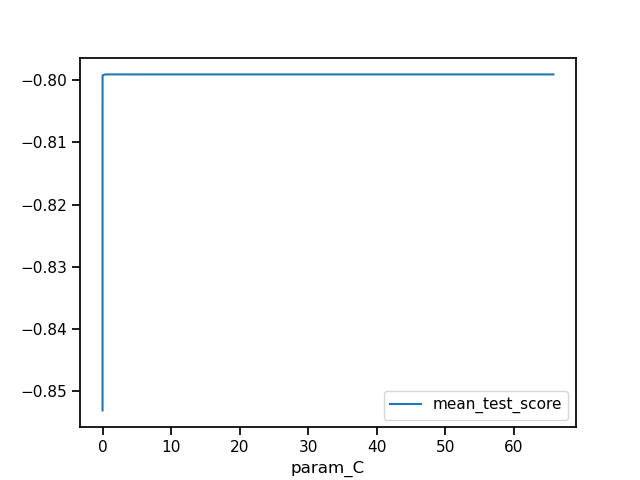

time: 9.03 s


In [15]:
df = tune(C=loguniform(1e-4, 1e4), results_df=df, n_iter=11)

Fitting 8 folds for each of 11 candidates, totalling 88 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best score: -0.7990444365237424
best params: {'C': 0.1192415990850905}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


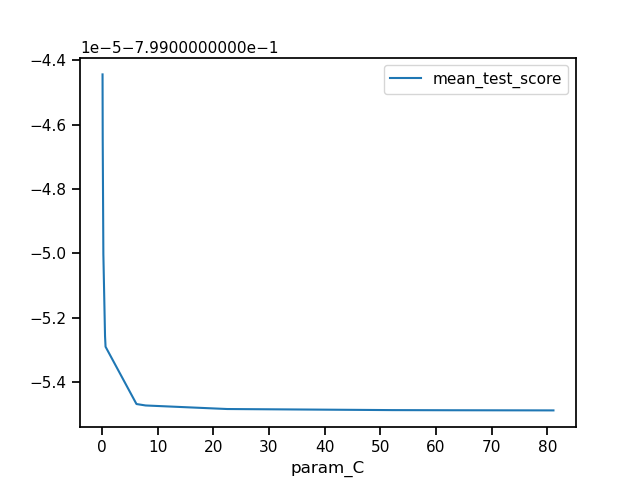

time: 10 s


In [16]:
df = tune(C=loguniform(0.1, 1000), results_df=df, n_iter=11)

Fitting 8 folds for each of 13 candidates, totalling 104 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best score: -0.7990496086077612
best params: {'C': 0.2442605141472523}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


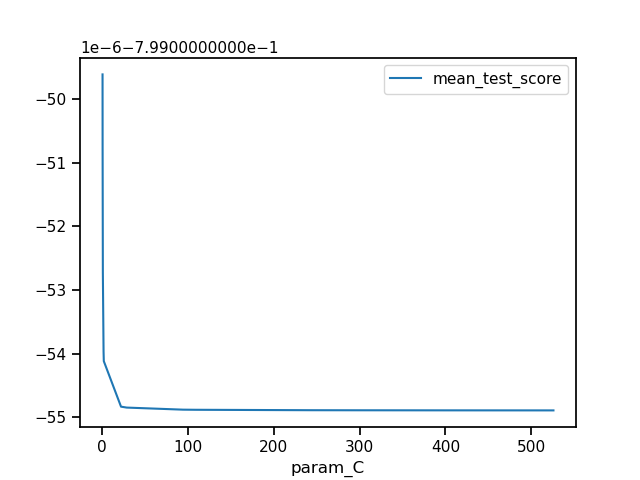

time: 11 s


In [17]:
df = tune(C=loguniform(0.2, 7000), results_df=df, n_iter=13)

Fitting 8 folds for each of 17 candidates, totalling 136 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best score: -0.7990503284776607
best params: {'C': 0.28405942115377136}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


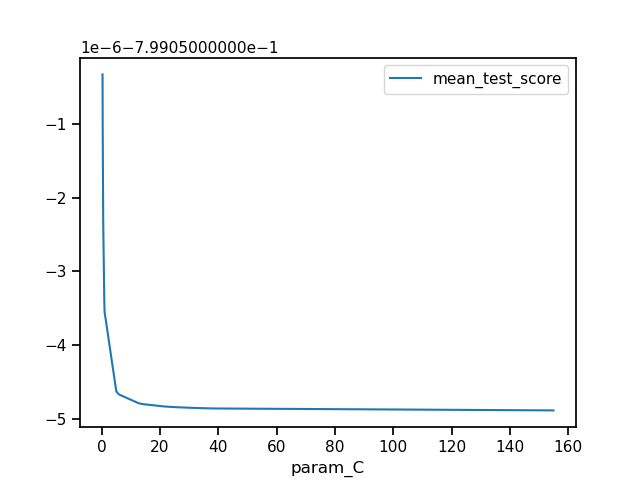

time: 14.7 s


In [18]:
df = tune(C=loguniform(0.25, 200), results_df=df, n_iter=17)

Fitting 8 folds for each of 13 candidates, totalling 104 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best score: -0.799048091587569
best params: {'C': 0.1879373922044296}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


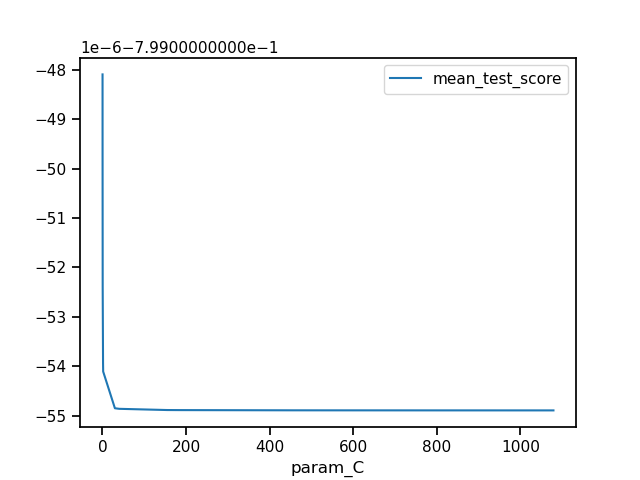

time: 10.8 s


In [19]:
df = tune(C=loguniform(0.15, 20000), results_df=df, n_iter=13)

Fitting 8 folds for each of 20 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best score: -0.7990097764383388
best params: {'C': 0.013455869304969958}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


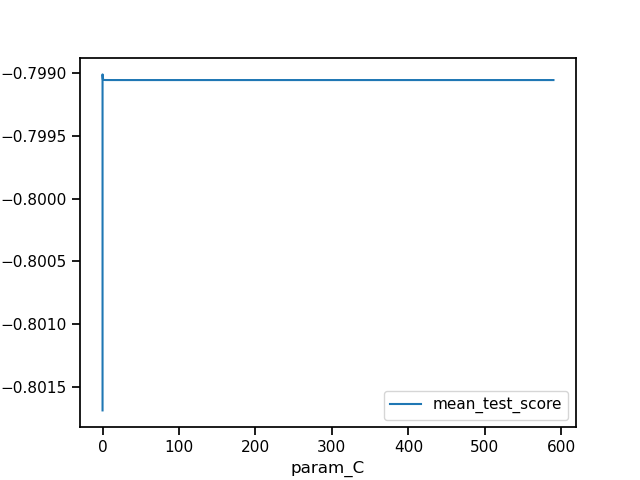

time: 15 s


In [20]:
df = tune(C=loguniform(1e-3, 1e3), results_df=df, n_iter=20)

Fitting 8 folds for each of 1000 candidates, totalling 8000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best score: -0.7990096207696106
best params: {'C': 0.014106918456367749}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


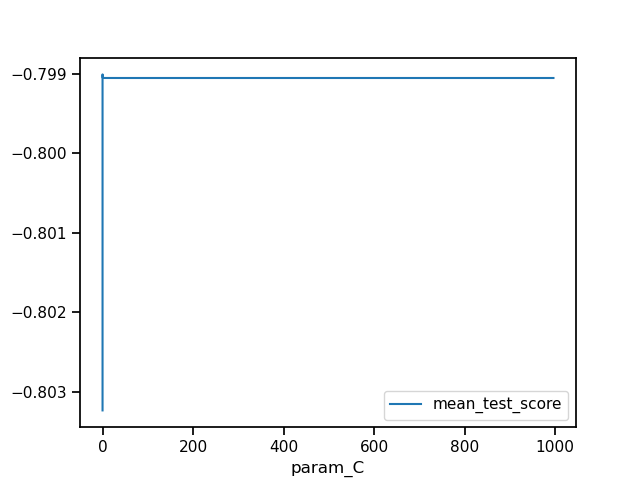

time: 10min 36s


In [21]:
df = tune(C=loguniform(1e-3, 1e3), results_df=df, n_iter=1000)

In [22]:
_ = gc_collect()

time: 195 ms


In [23]:
results_df = df
results_df.columns = results_df.columns.astype(str)
results_df.reset_index(drop=True).to_csv(f"{DATA_OUT_FOLDER}/logreg_results.csv")

time: 14 ms


<AxesSubplot:xlabel='param_C'>

,param_C,mean_test_score
758,0.014107,-0.799010
753,0.014083,-0.799010
648,0.014036,-0.799010
519,0.013905,-0.799010
137,0.014773,-0.799010
249,0.013819,-0.799010
202,0.013751,-0.799010
521,0.013499,-0.799010
842,0.015183,-0.799010
105,0.015212,-0.799010


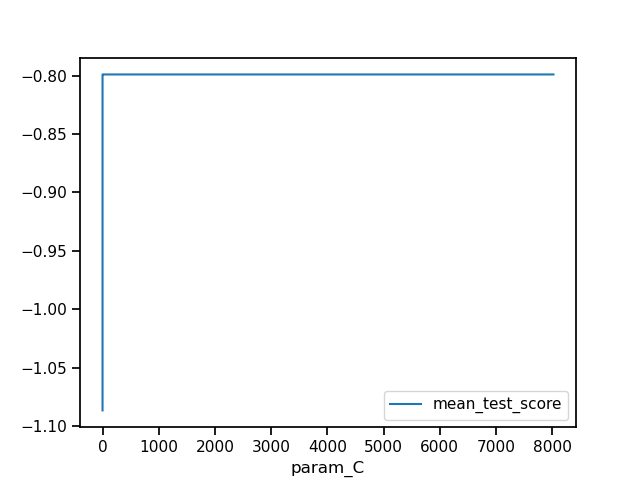

time: 249 ms


In [24]:
results_df = results_df.sort_values(by="param_C", ascending=True)
results_df.plot(x="param_C", y="mean_test_score")
df.sort_values(by="mean_test_score", ascending=False).head(100)

In [25]:
max_score = results_df.mean_test_score.max()
results_df.loc[results_df.mean_test_score == max_score]
results_df.loc[results_df.mean_test_score == max_score].param_C.iloc[0]

,param_C,mean_test_score
758,0.014107,-0.79901


0.014106918456367749

time: 11 ms


# Discussion

There are so many more possibilities for feature engineering. Upstream augmentation of the raw audio would probably be helpful as would resampling.

It's important to be disciplined now and focus on deployment. Although there are numerous points of interest where tweaking is likely to yield better results, we are only deviating slightly from the feature engineering pathway we already established.

In [26]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 747.22256731987 s
time: 197 ms


[^top](#Contents)